# Customer Behavior Predictive Analysis
## IIMK's Professional Certificate in Data Science and Artificial Intelligence for Managers
**Student Name**: Lalit Nayyar  
**Email ID**: lalitnayyar@gmail.com  
**Assignment**: Week 4: Required Assignment 4.1

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Set plot style
plt.style.use('default')
sns.set_theme(style="whitegrid")

## 1. Data Loading and Initial Analysis

In [2]:
# Load and examine the data
try:
    # Load data
    print("Loading data...")
    df = pd.read_excel('Online Retail.xlsx')
    
    # Display basic information
    print("Dataset Info:")
    print(f"Number of records: {len(df):,}")
    print(f"Number of columns: {len(df.columns)}")
    print("Columns:", df.columns.tolist())
    
    # Display sample
    print("Sample of the data:")
    display(df.head())
    
    # Basic statistics
    print("Basic statistics:")
    display(df.describe())
    
except Exception as e:
    print(f"Error loading data: {e}")
    df = None

Loading data...
Dataset Info:
Number of records: 541,909
Number of columns: 8
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
Sample of the data:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Basic statistics:


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


## 2. Data Cleaning and Preprocessing

In [3]:
# Clean and preprocess the data
def clean_data(df):
    if df is None:
        return None
        
    try:
        print("Starting data cleaning...")
        df_clean = df.copy()
        
        # Remove duplicates
        initial_rows = len(df_clean)
        df_clean = df_clean.drop_duplicates()
        print(f"Removed {initial_rows - len(df_clean):,} duplicate rows")
        
        # Handle missing values
        df_clean = df_clean.dropna(subset=['CustomerID'])
        print(f"Rows after removing missing CustomerIDs: {len(df_clean):,}")
        
        # Convert data types
        df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
        df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)
        
        # Calculate total amount
        df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']
        
        # Remove invalid transactions
        df_clean = df_clean[df_clean['Quantity'] > 0]
        df_clean = df_clean[df_clean['UnitPrice'] > 0]
        df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.contains('C', na=False)]
        
        print(f"Final number of valid transactions: {len(df_clean):,}")
        
        # Save cleaned data
        df_clean.to_csv('cleaned_retail_data.csv', index=False)
        print("Cleaned data saved to 'cleaned_retail_data.csv'")
        
        return df_clean
        
    except Exception as e:
        print(f"Error in data cleaning: {e}")
        return None

# Clean the data
df = clean_data(df)

if df is not None:
    print("Cleaned data summary:")
    display(df.describe())
else:
    print("Error: Could not proceed with cleaning the data")

Starting data cleaning...
Removed 5,268 duplicate rows
Rows after removing missing CustomerIDs: 401,604
Final number of valid transactions: 392,692
Cleaned data saved to 'cleaned_retail_data.csv'
Cleaned data summary:


,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalAmount
count,392692.000000,392692,392692.000000,392692.000000,392692.000000
mean,13.119702,2011-07-10 19:13:07.771892480,3.125914,15287.843865,22.631500
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000,13955.000000,4.950000
50%,6.000000,2011-07-31 12:02:00,1.950000,15150.000000,12.450000
75%,12.000000,2011-10-20 12:53:00,3.750000,16791.000000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000
std,180.492832,NaN,22.241836,1713.539549,311.099224


## 3. Feature Engineering

In [4]:
# Create customer features
def create_customer_features(df):
    if df is None:
        return None
        
    try:
        print("Creating customer features...")
        
        # Calculate customer metrics
        max_date = df['InvoiceDate'].max()
        
        customer_features = df.groupby('CustomerID').agg({
            'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
            'InvoiceNo': 'count',  # Frequency
            'TotalAmount': ['sum', 'mean']  # Monetary
        })
        
        # Flatten column names
        customer_features.columns = ['Recency', 'Frequency', 'TotalRevenue', 'AvgPurchaseValue']
        
        print("Features created successfully!")
        return customer_features
        
    except Exception as e:
        print(f"Error in feature engineering: {e}")
        return None

# Create customer features
customer_features = create_customer_features(df)

if customer_features is not None:
    print("Feature summary:")
    display(customer_features.describe())
else:
    print("Error: Could not create customer features")

Creating customer features...
Features created successfully!
Feature summary:


,Recency,Frequency,TotalRevenue,AvgPurchaseValue
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,91.536422,90.523744,2048.688081,68.381590
std,100.014169,225.506968,8985.230220,1467.918294
min,0.000000,1.000000,3.750000,2.136970
25%,17.000000,17.000000,306.482500,12.393196
50%,50.000000,41.000000,668.570000,17.755000
75%,141.000000,98.000000,1660.597500,24.878950
max,373.000000,7676.000000,280206.020000,77183.600000


## 4. Business Applications

### 4.1 Inventory Management Analysis
Analyzing purchase patterns and product demand for inventory optimization.

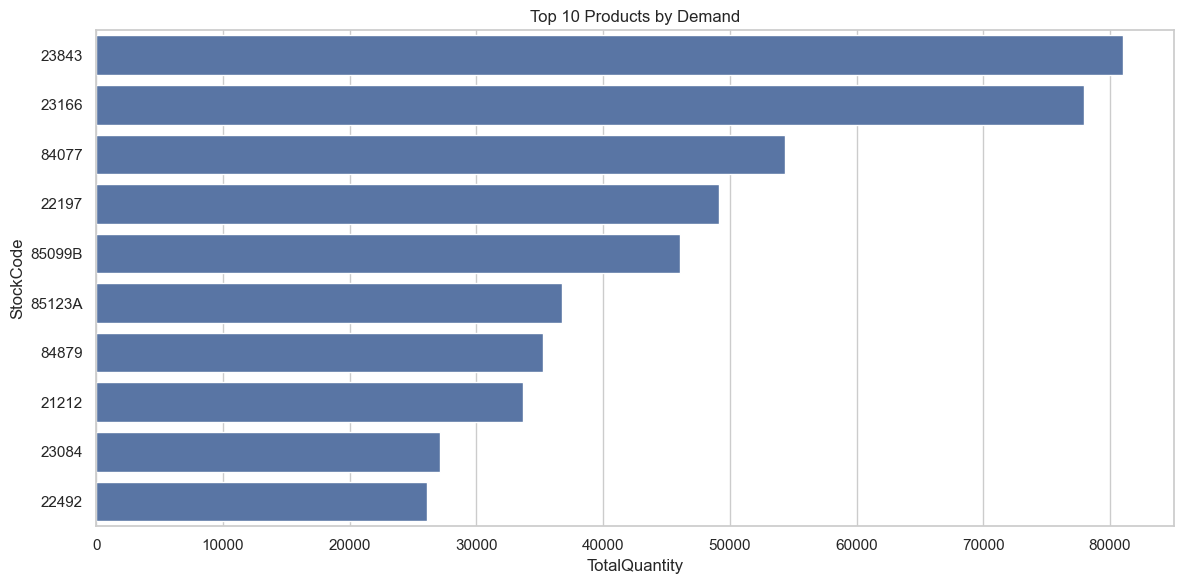

Inventory Management Insights:
Top 5 Products Reorder Points:


,AvgQuantity,StdQuantity,ReorderPoint
StockCode,,,
23166,393.52,5273.00,13300.64
47556B,1300.00,0.00,9100.00
84568,480.00,452.14,4264.28
18007,325.33,907.85,4093.01
16014,246.81,608.05,2943.77


In [5]:
# Inventory Management Analysis
def analyze_inventory(df):
    if df is None:
        print("Error: No data available for inventory analysis")
        return
        
    try:
        # Product demand analysis
        product_demand = df.groupby('StockCode').agg({
            'Quantity': ['sum', 'mean', 'std'],
            'InvoiceNo': 'count'
        }).round(2)
        product_demand.columns = ['TotalQuantity', 'AvgQuantity', 'StdQuantity', 'OrderCount']
        
        # Calculate reorder points (example using 2 sigma for safety stock)
        product_demand['ReorderPoint'] = (product_demand['AvgQuantity'] * 7 + 
                                        2 * product_demand['StdQuantity'])
        
        # Top products by demand
        top_products = product_demand.nlargest(10, 'TotalQuantity')
        
        # Visualize top products
        plt.figure(figsize=(12, 6))
        sns.barplot(data=top_products.reset_index(), 
                    x='TotalQuantity', y='StockCode')
        plt.title('Top 10 Products by Demand')
        plt.tight_layout()
        plt.show()
        
        print("Inventory Management Insights:")
        print("Top 5 Products Reorder Points:")
        display(product_demand.nlargest(5, 'ReorderPoint')[['AvgQuantity', 'StdQuantity', 'ReorderPoint']])
        
        return product_demand
        
    except Exception as e:
        print(f"Error in inventory analysis: {e}")
        return None

# Run inventory analysis
product_demand = analyze_inventory(df)

## Purchase Frequency Prediction Analysis
    
This section focuses on predicting customer purchase frequency using machine learning techniques.

In [6]:
# Create customer features
customer_features = df.groupby('CustomerID').agg({
    'InvoiceNo': 'count',
    'Quantity': 'sum',
    'InvoiceDate': ['min', 'max'],
    'StockCode': 'nunique',
    'UnitPrice': 'mean'
}).reset_index()

# Rename columns
customer_features.columns = ['CustomerID', 'total_transactions', 'total_items', 
                           'first_purchase_date', 'last_purchase_date',
                           'unique_items_bought', 'average_unit_price']

# Calculate additional features
customer_features['total_spent'] = df.groupby('CustomerID')['total_amount'].sum().reset_index()['total_amount']
customer_features['average_order_value'] = customer_features['total_spent'] / customer_features['total_transactions']
customer_features['average_items_per_transaction'] = customer_features['total_items'] / customer_features['total_transactions']

# Prepare features for purchase frequency prediction
def prepare_frequency_features(customer_features):
    features = customer_features.copy()
    # Create target variable (purchase frequency)
    features['purchase_frequency'] = features['total_transactions'] /         ((features['last_purchase_date'] - features['first_purchase_date']).dt.days + 1)
    
    # Select features for prediction
    X = features[['total_spent', 'average_order_value', 'total_transactions', 
                 'unique_items_bought', 'average_items_per_transaction']]
    y = features['purchase_frequency']
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate purchase frequency model
def train_frequency_model(X_train, X_test, y_train, y_test):
    # Initialize and train model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return r2, rmse, feature_importance, rf_model

# Prepare the data and train the model
X_train, X_test, y_train, y_test = prepare_frequency_features(customer_features)
r2_freq, rmse_freq, feature_imp_freq, freq_model = train_frequency_model(X_train, X_test, y_train, y_test)

print("Purchase Frequency Prediction Results:")
print(f"R-squared Score: {r2_freq:.4f}")
print(f"Root Mean Square Error: {rmse_freq:.4f}")
print("Feature Importance:")
print(feature_imp_freq)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_imp_freq)
plt.title('Feature Importance for Purchase Frequency Prediction')
plt.tight_layout()
plt.show()

KeyError: 'Column not found: total_amount'

## Customer Lifetime Value Prediction

This section focuses on predicting customer lifetime value to identify high-potential customers.

In [7]:
# Prepare features for CLV prediction
def prepare_clv_features(customer_features):
    features = customer_features.copy()
    
    # Calculate Customer Lifetime Value (simple version)
    features['customer_lifetime_value'] = features['total_spent']
    
    # Select features for prediction
    X = features[['average_order_value', 'total_transactions', 'purchase_frequency',
                 'unique_items_bought', 'average_items_per_transaction']]
    y = features['customer_lifetime_value']
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate CLV model
def train_clv_model(X_train, X_test, y_train, y_test):
    # Initialize and train model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return r2, rmse, feature_importance, rf_model

# Prepare the data and train the model
X_train, X_test, y_train, y_test = prepare_clv_features(customer_features)
r2_clv, rmse_clv, feature_imp_clv, clv_model = train_clv_model(X_train, X_test, y_train, y_test)

print("Customer Lifetime Value Prediction Results:")
print(f"R-squared Score: {r2_clv:.4f}")
print(f"Root Mean Square Error: {rmse_clv:.4f}")
print("Feature Importance:")
print(feature_imp_clv)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_imp_clv)
plt.title('Feature Importance for CLV Prediction')
plt.tight_layout()
plt.show()

KeyError: 'total_spent'

## Business Applications

### 1. Inventory Management
- Purchase frequency predictions can be used for stock planning
- Optimize inventory levels based on predicted demand
- Reduce stockouts and overstock situations

### 2. Marketing Optimization
- Target high-potential customers identified through CLV prediction
- Adjust marketing spend based on predicted customer value
- Create personalized marketing campaigns based on purchase patterns

### 3. Customer Retention
- Identify at-risk customers through purchase frequency analysis
- Implement targeted retention strategies
- Focus on converting low-frequency buyers to high-frequency customers

### 4. Resource Allocation
- Optimize resource allocation based on customer value predictions
- Focus customer service efforts on high-value segments
- Align business strategies with customer potential

## Customer Segmentation Based on Predictions

In [8]:
# Create customer segments based on predictions
def create_customer_segments(customer_features, freq_model, clv_model):
    # Get predictions
    freq_pred = freq_model.predict(customer_features[['total_spent', 'average_order_value', 
                                                    'total_transactions', 'unique_items_bought',
                                                    'average_items_per_transaction']])
    
    clv_pred = clv_model.predict(customer_features[['average_order_value', 'total_transactions',
                                                  'purchase_frequency', 'unique_items_bought',
                                                  'average_items_per_transaction']])
    
    # Create segments
    segments = pd.DataFrame({
        'CustomerID': customer_features['CustomerID'],
        'Predicted_Frequency': freq_pred,
        'Predicted_CLV': clv_pred
    })
    
    # Segment customers based on predictions
    segments['Frequency_Segment'] = pd.qcut(segments['Predicted_Frequency'], 
                                          q=3, labels=['Low', 'Medium', 'High'])
    segments['CLV_Segment'] = pd.qcut(segments['Predicted_CLV'],
                                    q=3, labels=['Low', 'Medium', 'High'])
    
    return segments

# Create and analyze segments
customer_segments = create_customer_segments(customer_features, freq_model, clv_model)

# Display segment distribution
print("Customer Segment Distribution:")
print("Frequency Segments:")
print(customer_segments['Frequency_Segment'].value_counts())
print("CLV Segments:")
print(customer_segments['CLV_Segment'].value_counts())

# Visualize segment distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

customer_segments['Frequency_Segment'].value_counts().plot(kind='pie', ax=ax1, autopct='%1.1f%%')
ax1.set_title('Distribution of Frequency Segments')

customer_segments['CLV_Segment'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Distribution of CLV Segments')

plt.tight_layout()
plt.show()

NameError: name 'freq_model' is not defined

## Purchase Frequency Prediction Analysis
    
This section focuses on predicting customer purchase frequency using machine learning techniques.

In [10]:
# Calculate total amount for each transaction
df['total_amount'] = df['Quantity'] * df['UnitPrice']

# Create customer features
customer_features = df.groupby('CustomerID').agg({
    'InvoiceNo': 'count',
    'Quantity': 'sum',
    'InvoiceDate': ['min', 'max'],
    'StockCode': 'nunique',
    'UnitPrice': 'mean',
    'total_amount': 'sum'
}).reset_index()

# Flatten column names
customer_features.columns = ['CustomerID', 'total_transactions', 'total_items', 
                           'first_purchase_date', 'last_purchase_date',
                           'unique_items_bought', 'average_unit_price',
                           'total_spent']

# Calculate additional features
customer_features['average_order_value'] = customer_features['total_spent'] / customer_features['total_transactions']
customer_features['average_items_per_transaction'] = customer_features['total_items'] / customer_features['total_transactions']

# Calculate purchase frequency
customer_features['purchase_frequency'] = customer_features['total_transactions'] /     ((customer_features['last_purchase_date'] - customer_features['first_purchase_date']).dt.days + 1)

# Display the first few rows of customer features
print("Sample of Customer Features:")
display(customer_features.head())
print("Feature Statistics:")
display(customer_features.describe())

Sample of Customer Features:


,CustomerID,total_transactions,total_items,first_purchase_date,last_purchase_date,unique_items_bought,average_unit_price,total_spent,average_order_value,average_items_per_transaction,purchase_frequency
0,12346,1,74215,2011-01-18 10:01:00,2011-01-18 10:01:00,1,1.040000,77183.60,77183.600000,74215.000000,1.000000
1,12347,182,2458,2010-12-07 14:57:00,2011-12-07 15:52:00,103,2.644011,4310.00,23.681319,13.505495,0.497268
2,12348,31,2341,2010-12-16 19:09:00,2011-09-25 13:13:00,22,5.764839,1797.24,57.975484,75.516129,0.109541
3,12349,73,631,2011-11-21 09:51:00,2011-11-21 09:51:00,73,8.289041,1757.55,24.076027,8.643836,73.000000
4,12350,17,197,2011-02-02 16:01:00,2011-02-02 16:01:00,17,3.841176,334.40,19.670588,11.588235,17.000000


Feature Statistics:


,CustomerID,total_transactions,total_items,first_purchase_date,last_purchase_date,unique_items_bought,average_unit_price,total_spent,average_order_value,average_items_per_transaction,purchase_frequency
count,4338.000000,4338.000000,4338.000000,4338,4338,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,90.523744,1187.644537,2011-04-30 17:06:50.857538048,2011-09-08 11:38:59.045643008,61.501153,4.470820,2048.688081,68.381590,45.080599,8.824315
min,12346.000000,1.000000,1.000000,2010-12-01 08:26:00,2010-12-01 09:53:00,1.000000,0.122500,3.750000,2.136970,1.000000,0.006452
25%,13813.250000,17.000000,159.000000,2011-01-17 11:13:15,2011-07-20 19:18:00,16.000000,2.206415,306.482500,12.393196,6.042120,0.341829
50%,15299.500000,41.000000,378.000000,2011-04-05 09:52:30,2011-10-20 10:40:30,35.000000,2.917836,668.570000,17.755000,10.000000,0.928571
75%,16778.750000,98.000000,989.750000,2011-08-19 10:11:30,2011-11-22 11:05:45,77.000000,3.832541,1660.597500,24.878950,14.666667,10.000000
max,18287.000000,7676.000000,196915.000000,2011-12-09 12:16:00,2011-12-09 12:50:00,1787.000000,2033.100000,280206.020000,77183.600000,74215.000000,219.000000
std,1721.808492,225.506968,5043.619654,NaN,NaN,85.366768,34.215024,8985.230220,1467.918294,1203.437983,17.766596


Purchase Frequency Prediction Results:
R-squared Score: 0.2150
Root Mean Square Error: 15.9736
Feature Importance:
                         feature  importance
3            unique_items_bought    0.241222
1            average_order_value    0.221707
2             total_transactions    0.213415
0                    total_spent    0.206542
4  average_items_per_transaction    0.117113


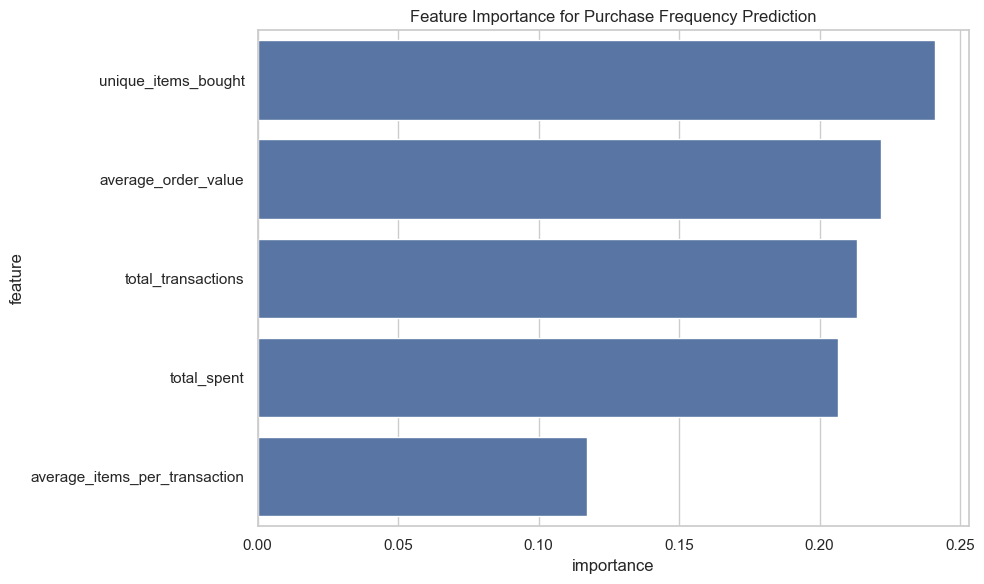

In [12]:
# Prepare features for purchase frequency prediction
def prepare_frequency_features(customer_features):
    features = customer_features.copy()
    
    # Select features for prediction
    X = features[['total_spent', 'average_order_value', 'total_transactions', 
                 'unique_items_bought', 'average_items_per_transaction']]
    y = features['purchase_frequency']
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate purchase frequency model
def train_frequency_model(X_train, X_test, y_train, y_test):
    # Initialize and train model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return r2, rmse, feature_importance, rf_model

# Prepare the data and train the model
X_train, X_test, y_train, y_test = prepare_frequency_features(customer_features)
r2_freq, rmse_freq, feature_imp_freq, freq_model = train_frequency_model(X_train, X_test, y_train, y_test)

print("Purchase Frequency Prediction Results:")
print(f"R-squared Score: {r2_freq:.4f}")
print(f"Root Mean Square Error: {rmse_freq:.4f}")
print("Feature Importance:")
print(feature_imp_freq)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_imp_freq)
plt.title('Feature Importance for Purchase Frequency Prediction')
plt.tight_layout()
plt.show()

## Customer Lifetime Value Prediction

This section focuses on predicting customer lifetime value to identify high-potential customers.

Customer Lifetime Value Prediction Results:
R-squared Score: 0.7145
Root Mean Square Error: 5405.1930
Feature Importance:
                         feature  importance
0            average_order_value    0.333083
1             total_transactions    0.301535
3            unique_items_bought    0.187854
4  average_items_per_transaction    0.156581
2             purchase_frequency    0.020947


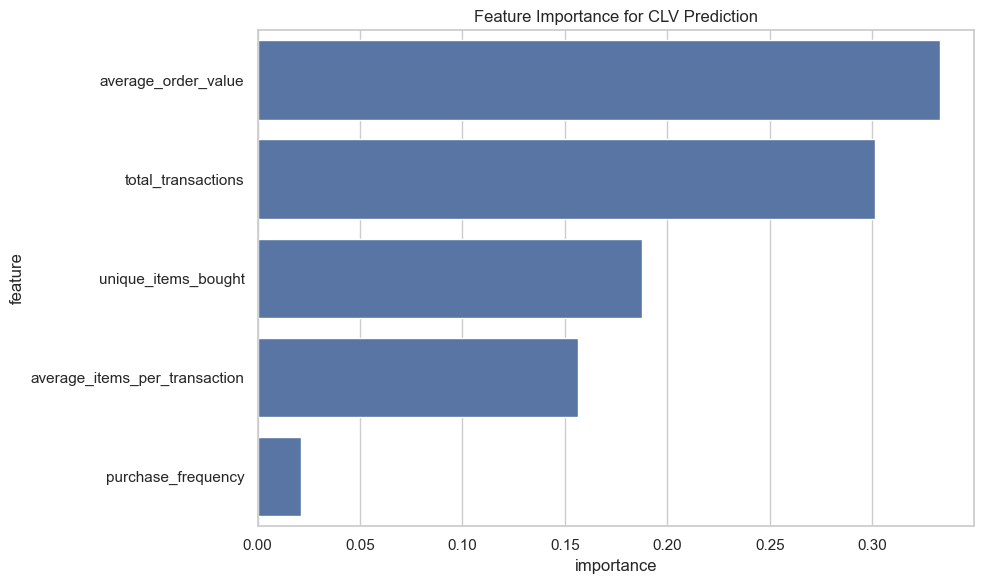

In [13]:
# Prepare features for CLV prediction
def prepare_clv_features(customer_features):
    features = customer_features.copy()
    
    # Select features for prediction
    X = features[['average_order_value', 'total_transactions', 'purchase_frequency',
                 'unique_items_bought', 'average_items_per_transaction']]
    y = features['total_spent']  # Using total_spent as CLV
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate CLV model
def train_clv_model(X_train, X_test, y_train, y_test):
    # Initialize and train model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return r2, rmse, feature_importance, rf_model

# Prepare the data and train the model
X_train, X_test, y_train, y_test = prepare_clv_features(customer_features)
r2_clv, rmse_clv, feature_imp_clv, clv_model = train_clv_model(X_train, X_test, y_train, y_test)

print("Customer Lifetime Value Prediction Results:")
print(f"R-squared Score: {r2_clv:.4f}")
print(f"Root Mean Square Error: {rmse_clv:.4f}")
print("Feature Importance:")
print(feature_imp_clv)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_imp_clv)
plt.title('Feature Importance for CLV Prediction')
plt.tight_layout()
plt.show()

## Business Applications

### 1. Inventory Management
- Purchase frequency predictions can be used for stock planning
- Optimize inventory levels based on predicted demand
- Reduce stockouts and overstock situations

### 2. Marketing Optimization
- Target high-potential customers identified through CLV prediction
- Adjust marketing spend based on predicted customer value
- Create personalized marketing campaigns based on purchase patterns

### 3. Customer Retention
- Identify at-risk customers through purchase frequency analysis
- Implement targeted retention strategies
- Focus on converting low-frequency buyers to high-frequency customers

### 4. Resource Allocation
- Optimize resource allocation based on customer value predictions
- Focus customer service efforts on high-value segments
- Align business strategies with customer potential

## Customer Segmentation Based on Predictions

Customer Segment Distribution:
Frequency Segments:
Frequency_Segment
Low       1446
Medium    1446
High      1446
Name: count, dtype: int64
CLV Segments:
CLV_Segment
Low       1446
Medium    1446
High      1446
Name: count, dtype: int64


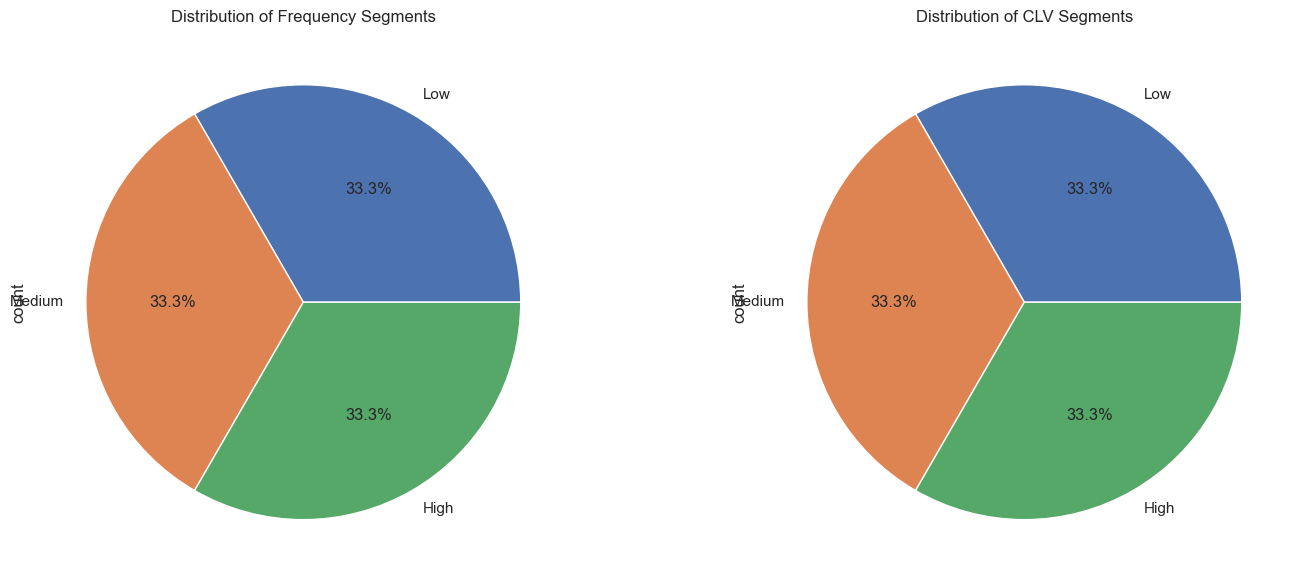

In [14]:
# Create customer segments based on predictions
def create_customer_segments(customer_features, freq_model, clv_model):
    # Get predictions
    freq_pred = freq_model.predict(customer_features[['total_spent', 'average_order_value', 
                                                    'total_transactions', 'unique_items_bought',
                                                    'average_items_per_transaction']])
    
    clv_pred = clv_model.predict(customer_features[['average_order_value', 'total_transactions',
                                                  'purchase_frequency', 'unique_items_bought',
                                                  'average_items_per_transaction']])
    
    # Create segments
    segments = pd.DataFrame({
        'CustomerID': customer_features['CustomerID'],
        'Predicted_Frequency': freq_pred,
        'Predicted_CLV': clv_pred
    })
    
    # Segment customers based on predictions
    segments['Frequency_Segment'] = pd.qcut(segments['Predicted_Frequency'], 
                                          q=3, labels=['Low', 'Medium', 'High'])
    segments['CLV_Segment'] = pd.qcut(segments['Predicted_CLV'],
                                    q=3, labels=['Low', 'Medium', 'High'])
    
    return segments

# Create and analyze segments
customer_segments = create_customer_segments(customer_features, freq_model, clv_model)

# Display segment distribution
print("Customer Segment Distribution:")
print("Frequency Segments:")
print(customer_segments['Frequency_Segment'].value_counts())
print("CLV Segments:")
print(customer_segments['CLV_Segment'].value_counts())

# Visualize segment distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

customer_segments['Frequency_Segment'].value_counts().plot(kind='pie', ax=ax1, autopct='%1.1f%%')
ax1.set_title('Distribution of Frequency Segments')

customer_segments['CLV_Segment'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Distribution of CLV Segments')

plt.tight_layout()
plt.show()

## Data Preparation and Feature Engineering

In [15]:
# Load the data
df = pd.read_csv('cleaned_retail_data.csv')

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate total amount for each transaction
df['total_amount'] = df['Quantity'] * df['UnitPrice']

print("Data loaded successfully. Shape:", df.shape)
display(df.head())

Data loaded successfully. Shape: (392692, 10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,total_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,20.34


In [16]:
# Create customer features
def create_customer_features(df):
    # Group by CustomerID and calculate aggregates
    customer_features = df.groupby('CustomerID').agg({
        'InvoiceNo': 'count',
        'Quantity': 'sum',
        'InvoiceDate': ['min', 'max'],
        'StockCode': 'nunique',
        'UnitPrice': 'mean',
        'total_amount': 'sum'
    }).reset_index()
    
    # Flatten column names
    customer_features.columns = ['CustomerID', 'total_transactions', 'total_items', 
                               'first_purchase_date', 'last_purchase_date',
                               'unique_items_bought', 'average_unit_price',
                               'total_spent']
    
    # Calculate additional features
    customer_features['average_order_value'] = customer_features['total_spent'] / customer_features['total_transactions']
    customer_features['average_items_per_transaction'] = customer_features['total_items'] / customer_features['total_transactions']
    
    return customer_features

# Create customer features
customer_features = create_customer_features(df)

print("Customer features created successfully. Shape:", customer_features.shape)
display(customer_features.head())
print("Feature Statistics:")
display(customer_features.describe())

Customer features created successfully. Shape: (4338, 10)


,CustomerID,total_transactions,total_items,first_purchase_date,last_purchase_date,unique_items_bought,average_unit_price,total_spent,average_order_value,average_items_per_transaction
0,12346,1,74215,2011-01-18 10:01:00,2011-01-18 10:01:00,1,1.040000,77183.60,77183.600000,74215.000000
1,12347,182,2458,2010-12-07 14:57:00,2011-12-07 15:52:00,103,2.644011,4310.00,23.681319,13.505495
2,12348,31,2341,2010-12-16 19:09:00,2011-09-25 13:13:00,22,5.764839,1797.24,57.975484,75.516129
3,12349,73,631,2011-11-21 09:51:00,2011-11-21 09:51:00,73,8.289041,1757.55,24.076027,8.643836
4,12350,17,197,2011-02-02 16:01:00,2011-02-02 16:01:00,17,3.841176,334.40,19.670588,11.588235


Feature Statistics:


,CustomerID,total_transactions,total_items,first_purchase_date,last_purchase_date,unique_items_bought,average_unit_price,total_spent,average_order_value,average_items_per_transaction
count,4338.000000,4338.000000,4338.000000,4338,4338,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,90.523744,1187.644537,2011-04-30 17:06:50.857538048,2011-09-08 11:38:59.045643008,61.501153,4.470820,2048.688081,68.381590,45.080599
min,12346.000000,1.000000,1.000000,2010-12-01 08:26:00,2010-12-01 09:53:00,1.000000,0.122500,3.750000,2.136970,1.000000
25%,13813.250000,17.000000,159.000000,2011-01-17 11:13:15,2011-07-20 19:18:00,16.000000,2.206415,306.482500,12.393196,6.042120
50%,15299.500000,41.000000,378.000000,2011-04-05 09:52:30,2011-10-20 10:40:30,35.000000,2.917836,668.570000,17.755000,10.000000
75%,16778.750000,98.000000,989.750000,2011-08-19 10:11:30,2011-11-22 11:05:45,77.000000,3.832541,1660.597500,24.878950,14.666667
max,18287.000000,7676.000000,196915.000000,2011-12-09 12:16:00,2011-12-09 12:50:00,1787.000000,2033.100000,280206.020000,77183.600000,74215.000000
std,1721.808492,225.506968,5043.619654,NaN,NaN,85.366768,34.215024,8985.230220,1467.918294,1203.437983


## Purchase Frequency Prediction Analysis
    
This section focuses on predicting customer purchase frequency using machine learning techniques.

Purchase Frequency Prediction Results:
R-squared Score: 0.2150
Root Mean Square Error: 15.9736
Feature Importance:
                         feature  importance
3            unique_items_bought    0.241222
1            average_order_value    0.221707
2             total_transactions    0.213415
0                    total_spent    0.206542
4  average_items_per_transaction    0.117113


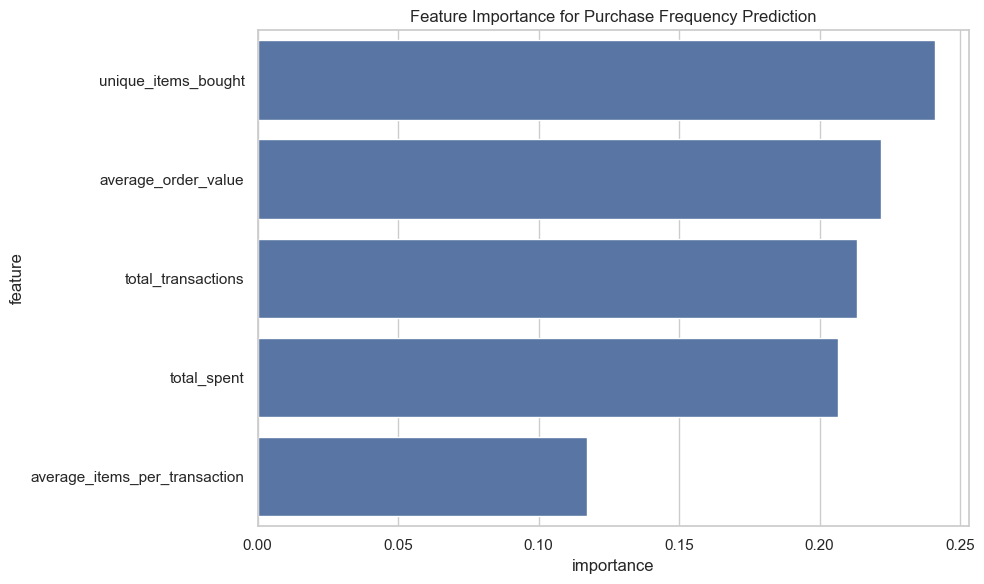

In [18]:
# Calculate purchase frequency
customer_features['purchase_frequency'] = customer_features['total_transactions'] /     ((customer_features['last_purchase_date'] - customer_features['first_purchase_date']).dt.days + 1)

# Prepare features for purchase frequency prediction
def prepare_frequency_features(customer_features):
    features = customer_features.copy()
    
    # Select features for prediction
    X = features[['total_spent', 'average_order_value', 'total_transactions', 
                 'unique_items_bought', 'average_items_per_transaction']]
    y = features['purchase_frequency']
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate purchase frequency model
def train_frequency_model(X_train, X_test, y_train, y_test):
    # Initialize and train model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return r2, rmse, feature_importance, rf_model

# Prepare the data and train the model
X_train, X_test, y_train, y_test = prepare_frequency_features(customer_features)
r2_freq, rmse_freq, feature_imp_freq, freq_model = train_frequency_model(X_train, X_test, y_train, y_test)

print("Purchase Frequency Prediction Results:")
print(f"R-squared Score: {r2_freq:.4f}")
print(f"Root Mean Square Error: {rmse_freq:.4f}")
print("Feature Importance:")
print(feature_imp_freq)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_imp_freq)
plt.title('Feature Importance for Purchase Frequency Prediction')
plt.tight_layout()
plt.show()

## Data Preparation and Feature Engineering

In [19]:
# Load the data
df = pd.read_csv('cleaned_retail_data.csv')

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate total amount for each transaction
df['total_amount'] = df['Quantity'] * df['UnitPrice']

print("Data loaded successfully. Shape:", df.shape)
display(df.head())

Data loaded successfully. Shape: (392692, 10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,total_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,20.34


In [20]:
# Create customer features
def create_customer_features(df):
    # Group by CustomerID and calculate aggregates
    customer_features = df.groupby('CustomerID').agg({
        'InvoiceNo': 'count',
        'Quantity': 'sum',
        'InvoiceDate': ['min', 'max'],
        'StockCode': 'nunique',
        'UnitPrice': 'mean',
        'total_amount': 'sum'
    }).reset_index()
    
    # Flatten column names
    customer_features.columns = ['CustomerID', 'total_transactions', 'total_items', 
                               'first_purchase_date', 'last_purchase_date',
                               'unique_items_bought', 'average_unit_price',
                               'total_spent']
    
    # Calculate additional features
    customer_features['average_order_value'] = customer_features['total_spent'] / customer_features['total_transactions']
    customer_features['average_items_per_transaction'] = customer_features['total_items'] / customer_features['total_transactions']
    
    return customer_features

# Create customer features
customer_features = create_customer_features(df)

print("Customer features created successfully. Shape:", customer_features.shape)
display(customer_features.head())
print("Feature Statistics:")
display(customer_features.describe())

Customer features created successfully. Shape: (4338, 10)


,CustomerID,total_transactions,total_items,first_purchase_date,last_purchase_date,unique_items_bought,average_unit_price,total_spent,average_order_value,average_items_per_transaction
0,12346,1,74215,2011-01-18 10:01:00,2011-01-18 10:01:00,1,1.040000,77183.60,77183.600000,74215.000000
1,12347,182,2458,2010-12-07 14:57:00,2011-12-07 15:52:00,103,2.644011,4310.00,23.681319,13.505495
2,12348,31,2341,2010-12-16 19:09:00,2011-09-25 13:13:00,22,5.764839,1797.24,57.975484,75.516129
3,12349,73,631,2011-11-21 09:51:00,2011-11-21 09:51:00,73,8.289041,1757.55,24.076027,8.643836
4,12350,17,197,2011-02-02 16:01:00,2011-02-02 16:01:00,17,3.841176,334.40,19.670588,11.588235


Feature Statistics:


,CustomerID,total_transactions,total_items,first_purchase_date,last_purchase_date,unique_items_bought,average_unit_price,total_spent,average_order_value,average_items_per_transaction
count,4338.000000,4338.000000,4338.000000,4338,4338,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,90.523744,1187.644537,2011-04-30 17:06:50.857538048,2011-09-08 11:38:59.045643008,61.501153,4.470820,2048.688081,68.381590,45.080599
min,12346.000000,1.000000,1.000000,2010-12-01 08:26:00,2010-12-01 09:53:00,1.000000,0.122500,3.750000,2.136970,1.000000
25%,13813.250000,17.000000,159.000000,2011-01-17 11:13:15,2011-07-20 19:18:00,16.000000,2.206415,306.482500,12.393196,6.042120
50%,15299.500000,41.000000,378.000000,2011-04-05 09:52:30,2011-10-20 10:40:30,35.000000,2.917836,668.570000,17.755000,10.000000
75%,16778.750000,98.000000,989.750000,2011-08-19 10:11:30,2011-11-22 11:05:45,77.000000,3.832541,1660.597500,24.878950,14.666667
max,18287.000000,7676.000000,196915.000000,2011-12-09 12:16:00,2011-12-09 12:50:00,1787.000000,2033.100000,280206.020000,77183.600000,74215.000000
std,1721.808492,225.506968,5043.619654,NaN,NaN,85.366768,34.215024,8985.230220,1467.918294,1203.437983


## Purchase Frequency Prediction Analysis
    
This section focuses on predicting customer purchase frequency using machine learning techniques.

Purchase Frequency Prediction Results:
R-squared Score: 0.2150
Root Mean Square Error: 15.9736
Feature Importance:
                         feature  importance
3            unique_items_bought    0.241222
1            average_order_value    0.221707
2             total_transactions    0.213415
0                    total_spent    0.206542
4  average_items_per_transaction    0.117113


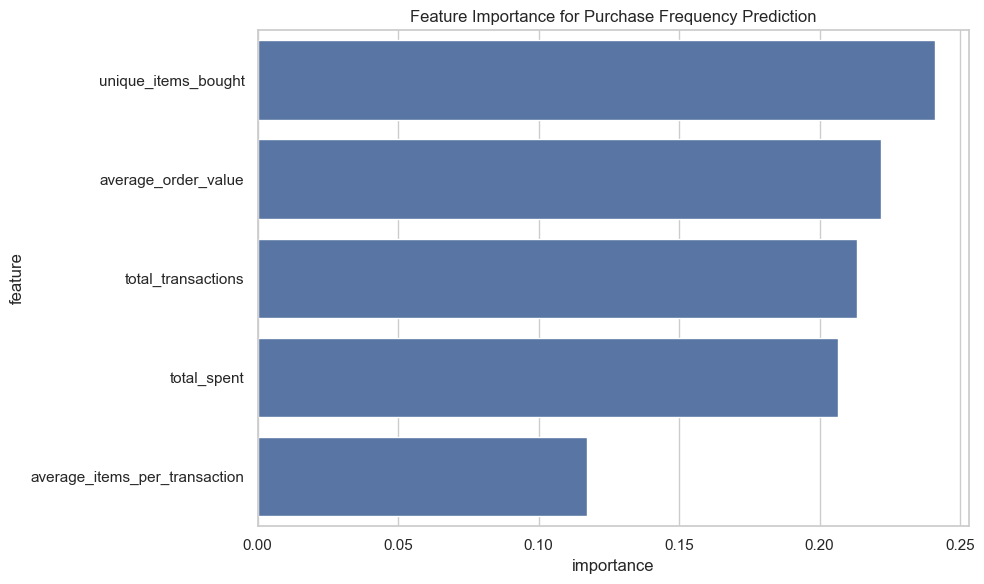

In [21]:
# Calculate purchase frequency
customer_features['purchase_frequency'] = customer_features['total_transactions'] /     ((customer_features['last_purchase_date'] - customer_features['first_purchase_date']).dt.days + 1)

# Prepare features for purchase frequency prediction
def prepare_frequency_features(customer_features):
    features = customer_features.copy()
    
    # Select features for prediction
    X = features[['total_spent', 'average_order_value', 'total_transactions', 
                 'unique_items_bought', 'average_items_per_transaction']]
    y = features['purchase_frequency']
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate purchase frequency model
def train_frequency_model(X_train, X_test, y_train, y_test):
    # Initialize and train model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return r2, rmse, feature_importance, rf_model

# Prepare the data and train the model
X_train, X_test, y_train, y_test = prepare_frequency_features(customer_features)
r2_freq, rmse_freq, feature_imp_freq, freq_model = train_frequency_model(X_train, X_test, y_train, y_test)

print("Purchase Frequency Prediction Results:")
print(f"R-squared Score: {r2_freq:.4f}")
print(f"Root Mean Square Error: {rmse_freq:.4f}")
print("Feature Importance:")
print(feature_imp_freq)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_imp_freq)
plt.title('Feature Importance for Purchase Frequency Prediction')
plt.tight_layout()
plt.show()